## Information

Within the deadline of this project it was not possible to make the data preparation reproducible (mainly augmentation). Therefore running the cells for training of this notebook subsequent times will result in slightly different results. See listed oberservations below the different training runs.

In [1]:
import os
import sys
import logging
import shutil

import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from numba import cuda

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

workspace_dir = os.environ.get('WORKSPACE_DIR', '/workspace')

path_lib_dir = os.path.join(workspace_dir, 'lib')
# check if path has been added
if os.path.dirname(os.path.abspath(path_lib_dir)) not in sys.path:
    sys.path.append(path_lib_dir)

from lib.dataset import Dataset
from lib.augment import Processing

logging.basicConfig(level=logging.INFO)

# jupyter notebook make changes in imports to update without restarting kernel
%load_ext autoreload
%autoreload 2


2023-12-19 07:59:20.569543: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 07:59:20.569585: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 07:59:20.569607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 07:59:20.576232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Check TensorFlow version

In [2]:
tf.__version__

'2.14.0'

Check for GPU support

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    device = cuda.get_current_device()
    device.reset()
else:
    print("GPU not available")

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

INFO:numba.cuda.cudadrv.driver:init
INFO:numba.cuda.cudadrv.driver:reset context of device 0


GPU is available
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


2023-12-19 07:59:24.332398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22982 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-12-19 07:59:24.333432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22982 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5


Load the dataset

In [4]:
seed = 1234
# Set the seed for reproducibility
# tf.config.experimental.enable_op_determinism()

os.environ['PYTHONHASHSEED'] = '0'
tf.keras.utils.set_random_seed(seed)

dataset = Dataset(seed=seed, dataset_name='rock_paper_scissors')
dataset.load(validation_proportion=0.15)

ds_train = dataset.ds_train
ds_val = dataset.ds_val

# retrieve length of dataset from ds_train
len_ds_train = len(ds_train)
len_ds_val = len(ds_val)
len_ds_test = len(dataset.ds_test)

2023-12-19 07:59:24.408607: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: rock_paper_scissors/3.0.0
INFO:absl:Load dataset info from /tmp/tmp2gv2u0z0tfds
INFO:absl:For 'rock_paper_scissors/3.0.0': fields info.[release_notes, citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Generating dataset rock_paper_scissors (/root/tensorflow_datasets/rock_paper_scissors/3.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

INFO:absl:Downloading https://storage.googleapis.com/download.tensorflow.org/data/rps.zip into /root/tensorflow_datasets/downloads/download.tensorflow.org_rpsTMU28Xht1ozVKdpCeg3kDRlBWpd13hOLn7JRfNOZTQ4.zip.tmp.16cf00bb3738448abd5c5594ed989a41...
INFO:absl:Downloading https://storage.googleapis.com/download.tensorflow.org/data/rps-test-set.zip into /root/tensorflow_datasets/downloads/download.tensorflow.org_rps-test-setZxuwAQcXW8uy7_Rn09Ws1b25tO58FOU9H0n5KAPMrSI.zip.tmp.e3f1aeed9a054b549412935cadfc135f...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete2HAFCF/rock_paper_scissors-train.tfrec…

INFO:absl:Done writing /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete2HAFCF/rock_paper_scissors-train.tfrecord*. Number of examples: 2520 (shards: [1260, 1260])


Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete2HAFCF/rock_paper_scissors-test.tfreco…

INFO:absl:Done writing /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete2HAFCF/rock_paper_scissors-test.tfrecord*. Number of examples: 372 (shards: [372])
2023-12-19 07:59:38.882381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22982 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5
INFO:absl:Constructing tf.data.Dataset rock_paper_scissors for split ['train'], from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Reusing dataset rock_paper_scissors (/root/tensorflow_datasets/rock_paper_scissors/3.0.0)


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


INFO:absl:Constructing tf.data.Dataset rock_paper_scissors for split ['train[:2142]', 'train[2142:]', 'test'], from /root/tensorflow_datasets/rock_paper_scissors/3.0.0


Check number of images per split

In [6]:
len_ds_train, len_ds_val, len_ds_test

(2142, 378, 372)

In [7]:
# get cpu threads 
cpu_count = os.cpu_count()
workers = max(1, cpu_count - 2)
print('cpu_count', cpu_count)
print('workers', workers)

cpu_count 12
workers 10


Function for preparing the dataset

In [8]:
def prepare_dataset(ds, seed, target_size=(224, 224), batch_size=64, augment=True, shuffle=True):
    preprocessing = Processing(
        random_flip_left_right=True,
        random_brightness=0.1,
        random_contrast=0.1,
        random_rotation=180,
        random_saturation=0.1,
        random_hue=0.05,
        random_crop=0.05,
        random_translate=0.05,
        random_zoom=0.05,
    )
    ds_prepared = ds.cache()
    # ds_prepared = ds
    if shuffle:
        ds_prepared = ds_prepared.shuffle(len(ds_prepared), seed=seed)
    ds_prepared = preprocessing.preprocess(ds_prepared, target_size, augment)
    ds_prepared = ds_prepared.batch(batch_size)
    ds_prepared = ds_prepared.prefetch(tf.data.AUTOTUNE)
    return ds_prepared

In [9]:
overview_models = { }

Following best practice from
https://www.tensorflow.org/guide/keras/transfer_learning

Function for creating the model

In [10]:
def create_model(model_class, seed, target_size=(160, 160), dropout_rate=0.2, optimizer=tf.keras.optimizers.legacy.Adam()):
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(seed)
    input_shape=target_size + (3,)
    seed_init = seed
    base_model = model_class(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # freeze base model
    base_model.trainable = False
    # set base model to inference mode (not training)
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # add head comparable to original MobileNetV2
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
     # add additional layers in case of dropout is not None
    if dropout_rate is not None:
        # Add a fully-connected layer
        seed_init += 1
        initializer = tf.keras.initializers.GlorotUniform(seed=seed_init)
        x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=initializer)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    seed_init += 1
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_init)
    outputs = tf.keras.layers.Dense(3, activation='softmax', kernel_initializer=initializer)(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Function for training the model

In [11]:
def train_model(
        model, 
        model_name, 
        overview_models, 
        ds_train, 
        ds_val,
        seed, 
        target_size, 
        workers,
        batch_size=64,
        epochs=20,
        callbacks=None,
        ):
    tf.keras.utils.set_random_seed(seed)
    ds_train_prepared = prepare_dataset(
        ds_train, seed, target_size=target_size, batch_size=batch_size, augment=True, shuffle=True)
    ds_val_prepared = prepare_dataset(
        ds_val, seed, target_size=target_size, batch_size=batch_size, augment=False, shuffle=False)

    #ds_train_prepared = ds_train_prepared.repeat()
    history = model.fit(
        ds_train_prepared,
        epochs=epochs,
        # batch_size=batch_size,
        validation_data=ds_val_prepared,
        workers=workers,
        callbacks=callbacks,
    )

    y_true = np.concatenate([y for x, y in ds_val_prepared], axis=0)
    y_pred = np.argmax(model.predict(ds_val_prepared), axis=1)
    cm = confusion_matrix(y_true, y_pred)

    overview_models[model_name] = {}
    overview_models[model_name]['model'] = model
    overview_models[model_name]['num_params'] = model.count_params()
    overview_models[model_name]['history'] = history.history
    overview_models[model_name]['cm'] = cm

    return overview_models


Function for plotting the history (dict for different models and histories)

In [12]:
def plot_history(overview_models, plot_model_size=True, ymin_accuracy=None, ymax_accuracy=None, ymin_loss=None, ymax_loss=None):
    nplot = 3 if plot_model_size else 2
    plt.figure(figsize=(nplot*6, 5))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    alpha = 0.6
    # Plot training & validation accuracy values
    plt.subplot(1, nplot, 1)
    for i, (model_name, overview) in enumerate(overview_models.items()):
        history = overview['history']
        color = colors[i % len(colors)]
        plt.plot(history['accuracy'], label=f'{model_name} Train', linestyle='solid', color=color, alpha=alpha)
        plt.plot(history['val_accuracy'], label=f'{model_name} Validation', linestyle='dashed', color=color, alpha=alpha)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    if ymin_accuracy is not None:
        plt.ylim(ymin_accuracy, 1 if ymax_accuracy is None else ymax_accuracy)
        
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, nplot, 2)
    for i, (model_name, overview) in enumerate(overview_models.items()):
        history = overview['history']
        color = colors[i % len(colors)]
        plt.plot(history['loss'], label=f'{model_name} Train', linestyle='solid', color=color)
        plt.plot(history['val_loss'], label=f'{model_name} Validation', linestyle='dashed', color=color)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    if ymax_loss is not None:
        plt.ylim(0 if ymin_loss is None else ymin_loss, ymax_loss)
    plt.legend()

    if plot_model_size:
        # Plot model size vs validation accuracy in the last epoch
        plt.subplot(1, 3, 3)
        min_val = np.inf
        max_val = 0
        for i, (model_name, overview) in enumerate(overview_models.items()):
            history = overview['history']
            model_size = overview['num_params']
            val_accuracy_last_epoch = history['val_accuracy'][-1]
            plt.scatter(model_size, val_accuracy_last_epoch, color=colors[i % len(colors)], label=model_name, alpha=alpha)
            min_val = min(min_val, model_size)
            max_val = max(max_val, model_size)
        plt.title('Model size vs Validation accuracy')
        plt.xlim(min_val*0.9, max_val*1.1)
        plt.ylabel('Validation accuracy in the last epoch')
        plt.xlabel('Model size')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def plot_cm(overview_models):
    num_models = len(overview_models)
    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(3*num_models, 3))

    for ax, (model_name, model_info) in zip(axes, overview_models.items()):
        # Get the confusion matrix
        cm = model_info['cm']
        cm_normalized = normalize(cm, axis=1, norm='l1')

        cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

        for i in range(cm_normalized.shape[0]):
            for j in range(cm_normalized.shape[1]):
                ax.text(j, i, f"{cm_normalized[i, j]:.2f}\n({cm[i, j]})", ha="center", va="center", color="red")

    plt.suptitle('Confusion Matrices, normalized value, absolute values in brackets')
    plt.tight_layout()
    plt.show()

## Selecting the base model

Selecting different base models for applying Transfer-Learning

In [14]:
func_mobilenetv2 = tf.keras.applications.MobileNetV2
func_densenet121 = tf.keras.applications.DenseNet121

target_size_mobilenetv2 = (160, 160)
target_size_densenet121 = (200, 200)

Training models using the smallest supported input image size for each base model.

In [15]:
epochs = 20
batch_size = 64
dropout_rate = None

logging.info(f'training model MobileNetV2')
model_mobilenetv2 = create_model(func_mobilenetv2, seed=seed, target_size=target_size_mobilenetv2, dropout_rate=dropout_rate)
overview = train_model(
    model_mobilenetv2, 
    'MobileNetV2', 
    overview_models, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size_mobilenetv2, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)

logging.info(f'training model DenseNet121')
model_densenet121 = create_model(func_densenet121, seed=seed, target_size=target_size_densenet121, dropout_rate=dropout_rate)
overview = train_model(
    model_densenet121, 
    'DenseNet121', 
    overview_models, 
    ds_train, 
    dataset.ds_val, 
    seed, 
    target_size=target_size_densenet121, 
    workers=workers,
    batch_size=batch_size,  
    epochs=epochs,
)

INFO:root:training model MobileNetV2


9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/20


2023-12-19 08:00:42.961713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


34/34 [==============================] - 12s 187ms/step - loss: 0.7586 - accuracy: 0.6858 - val_loss: 0.3818 - val_accuracy: 0.8677
Epoch 2/20
34/34 [==============================] - 5s 143ms/step - loss: 0.2793 - accuracy: 0.9346 - val_loss: 0.2135 - val_accuracy: 0.9497
Epoch 3/20
34/34 [==============================] - 5s 142ms/step - loss: 0.1771 - accuracy: 0.9566 - val_loss: 0.1730 - val_accuracy: 0.9550
Epoch 4/20
34/34 [==============================] - 5s 142ms/step - loss: 0.1401 - accuracy: 0.9664 - val_loss: 0.1588 - val_accuracy: 0.9550
Epoch 5/20
34/34 [==============================] - 5s 143ms/step - loss: 0.1144 - accuracy: 0.9762 - val_loss: 0.1349 - val_accuracy: 0.9656
Epoch 6/20
34/34 [==============================] - 5s 149ms/step - loss: 0.0904 - accuracy: 0.9837 - val_loss: 0.1083 - val_accuracy: 0.9709
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0774 - accuracy: 0.9869 - val_loss: 0.1145 - val_accuracy: 0.9709
Epoch 8/20
34/34

INFO:root:training model DenseNet121


29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/20
34/34 [==============================] - 21s 328ms/step - loss: 0.5180 - accuracy: 0.8035 - val_loss: 0.2987 - val_accuracy: 0.9048
Epoch 2/20
34/34 [==============================] - 7s 198ms/step - loss: 0.1720 - accuracy: 0.9566 - val_loss: 0.2498 - val_accuracy: 0.9206
Epoch 3/20
34/34 [==============================] - 7s 197ms/step - loss: 0.1258 - accuracy: 0.9687 - val_loss: 0.1724 - val_accuracy: 0.9471
Epoch 4/20
34/34 [==============================] - 7s 197ms/step - loss: 0.1098 - accuracy: 0.9743 - val_loss: 0.1577 - val_accuracy: 0.9550
Epoch 5/20
34/34 [==============================] - 7s 196ms/step - loss: 0.0977 - accuracy: 0.9809 - val_loss: 0.1443 - val_accuracy: 0.9656
Epoch 6/20
34/34 [==============================] - 7s 195ms/step - loss: 0.0836 - accuracy: 0.9837 - val_loss: 0.1373 - val_accuracy: 0.9497
Epoch 7/20
34/34 [==============================] - 7s 197ms/step - loss: 0.0809 -

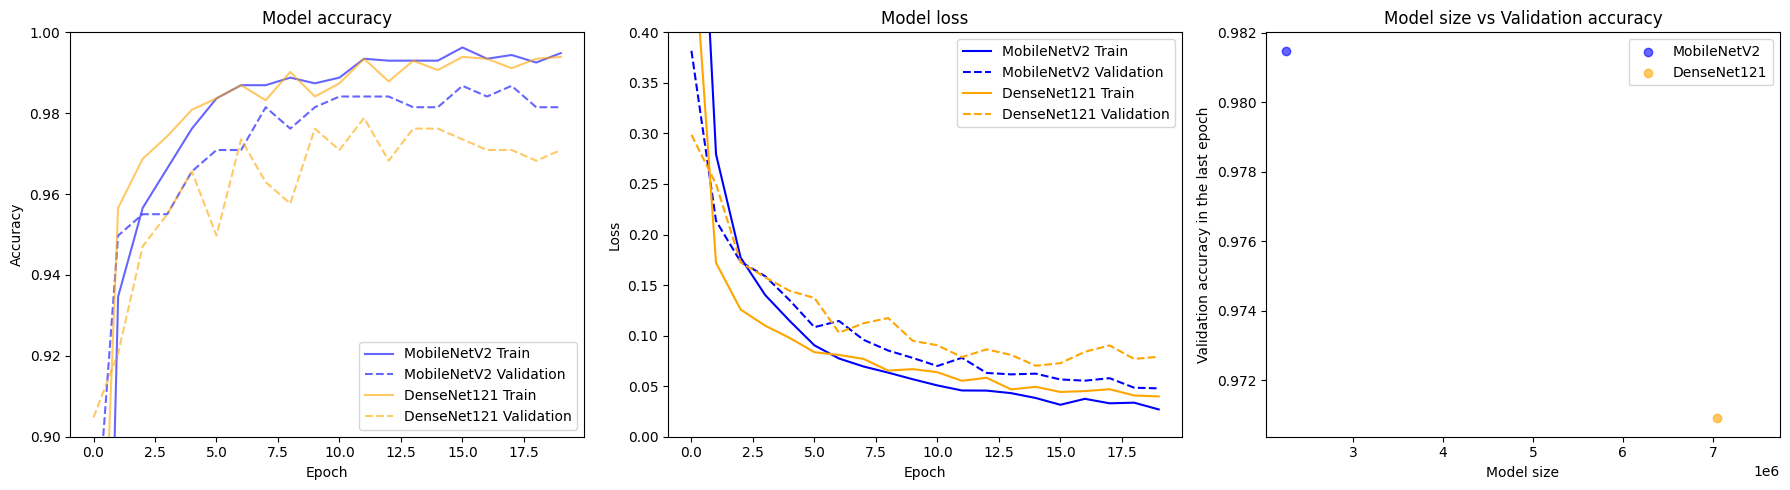

In [16]:
plot_history(overview_models, ymin_accuracy=0.9, ymax_loss=0.4)

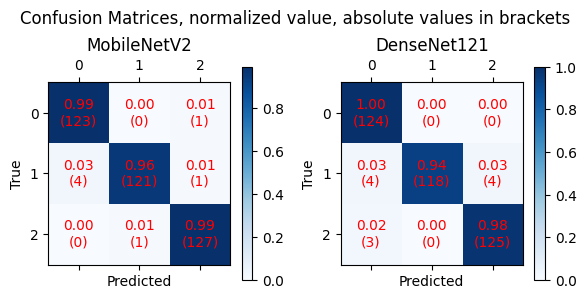

In [17]:
plot_cm(overview_models)

The following has been observed when running this training step mutliple times:

- Most of the time the MobileNetv2 performs better the DenseNet121.

MobileNetv2 with input size (160,160) has less parameter than DenseNet121 with input size (200,200). 

Therefore deciding to chose the smaller MobileNetv2 model for further investigations.


---

## Starting hyperparameter tuning

### Additional layer with different dropout rates

Trying out an additional layer with different dropout rates. 

Comparing the MobileNetv2 model from the previous training run (without additional layer) to the models with additional layer (different dropout rates).

In [21]:
overview_mobilenetv2 = {}
overview_mobilenetv2['MobileNetV2'] = overview_models['MobileNetV2']

epochs=20
target_size=(160, 160)
batch_size=64

for dropout_rate in [0.0, 0.2, 0.4, 0.6]:
    logging.info(f'training model MobileNetV2 - additional layer with dropout {dropout_rate}')
    model_mobilenetv2_dropout = create_model(func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate)
    overview_mobilenetv2 = train_model(
        model_mobilenetv2_dropout, 
        f'MobileNetV2 dropout {dropout_rate}', 
        overview_mobilenetv2, 
        ds_train, 
        ds_val, 
        seed, 
        target_size=target_size, 
        workers=workers,
        batch_size=batch_size,
        epochs=epochs,
    )

INFO:root:training model MobileNetV2 - additional layer with dropout 0.0


Epoch 1/20
34/34 [==============================] - 11s 205ms/step - loss: 1.7939 - accuracy: 0.7703 - val_loss: 0.1316 - val_accuracy: 0.9524
Epoch 2/20
34/34 [==============================] - 5s 145ms/step - loss: 0.0688 - accuracy: 0.9804 - val_loss: 0.0625 - val_accuracy: 0.9788
Epoch 3/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0454 - accuracy: 0.9841 - val_loss: 0.1110 - val_accuracy: 0.9577
Epoch 4/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0292 - accuracy: 0.9893 - val_loss: 0.0337 - val_accuracy: 0.9894
Epoch 5/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0290 - val_accuracy: 0.9894
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 0.0321 - val_accuracy: 0.9868
Epoch 7/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0271 - val_accuracy: 0.9894
Epoch

INFO:root:training model MobileNetV2 - additional layer with dropout 0.2


Epoch 1/20
34/34 [==============================] - 10s 176ms/step - loss: 1.7820 - accuracy: 0.7596 - val_loss: 0.1526 - val_accuracy: 0.9444
Epoch 2/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0958 - accuracy: 0.9701 - val_loss: 0.0955 - val_accuracy: 0.9656
Epoch 3/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0462 - accuracy: 0.9874 - val_loss: 0.0543 - val_accuracy: 0.9788
Epoch 4/20
34/34 [==============================] - 5s 142ms/step - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.0775 - val_accuracy: 0.9762
Epoch 5/20
34/34 [==============================] - 5s 142ms/step - loss: 0.0253 - accuracy: 0.9930 - val_loss: 0.0463 - val_accuracy: 0.9788
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0221 - accuracy: 0.9939 - val_loss: 0.0328 - val_accuracy: 0.9841
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.0680 - val_accuracy: 0.9735
Epoch

INFO:root:training model MobileNetV2 - additional layer with dropout 0.4


Epoch 1/20
34/34 [==============================] - 10s 174ms/step - loss: 1.8489 - accuracy: 0.7745 - val_loss: 0.1701 - val_accuracy: 0.9550
Epoch 2/20
34/34 [==============================] - 5s 144ms/step - loss: 0.1089 - accuracy: 0.9622 - val_loss: 0.0804 - val_accuracy: 0.9735
Epoch 3/20
34/34 [==============================] - 5s 142ms/step - loss: 0.0517 - accuracy: 0.9855 - val_loss: 0.0648 - val_accuracy: 0.9709
Epoch 4/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0511 - accuracy: 0.9818 - val_loss: 0.0526 - val_accuracy: 0.9815
Epoch 5/20
34/34 [==============================] - 5s 142ms/step - loss: 0.0378 - accuracy: 0.9911 - val_loss: 0.0681 - val_accuracy: 0.9735
Epoch 6/20
34/34 [==============================] - 5s 142ms/step - loss: 0.0299 - accuracy: 0.9907 - val_loss: 0.0393 - val_accuracy: 0.9921
Epoch 7/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0346 - accuracy: 0.9893 - val_loss: 0.0637 - val_accuracy: 0.9762
Epoch

INFO:root:training model MobileNetV2 - additional layer with dropout 0.6


Epoch 1/20
34/34 [==============================] - 11s 176ms/step - loss: 1.5772 - accuracy: 0.7670 - val_loss: 0.1577 - val_accuracy: 0.9550
Epoch 2/20
34/34 [==============================] - 5s 144ms/step - loss: 0.1194 - accuracy: 0.9599 - val_loss: 0.1302 - val_accuracy: 0.9630
Epoch 3/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0770 - accuracy: 0.9753 - val_loss: 0.0933 - val_accuracy: 0.9683
Epoch 4/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0534 - accuracy: 0.9795 - val_loss: 0.0451 - val_accuracy: 0.9815
Epoch 5/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0565 - val_accuracy: 0.9788
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0388 - accuracy: 0.9837 - val_loss: 0.0901 - val_accuracy: 0.9709
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0345 - accuracy: 0.9865 - val_loss: 0.0470 - val_accuracy: 0.9762
Epoch

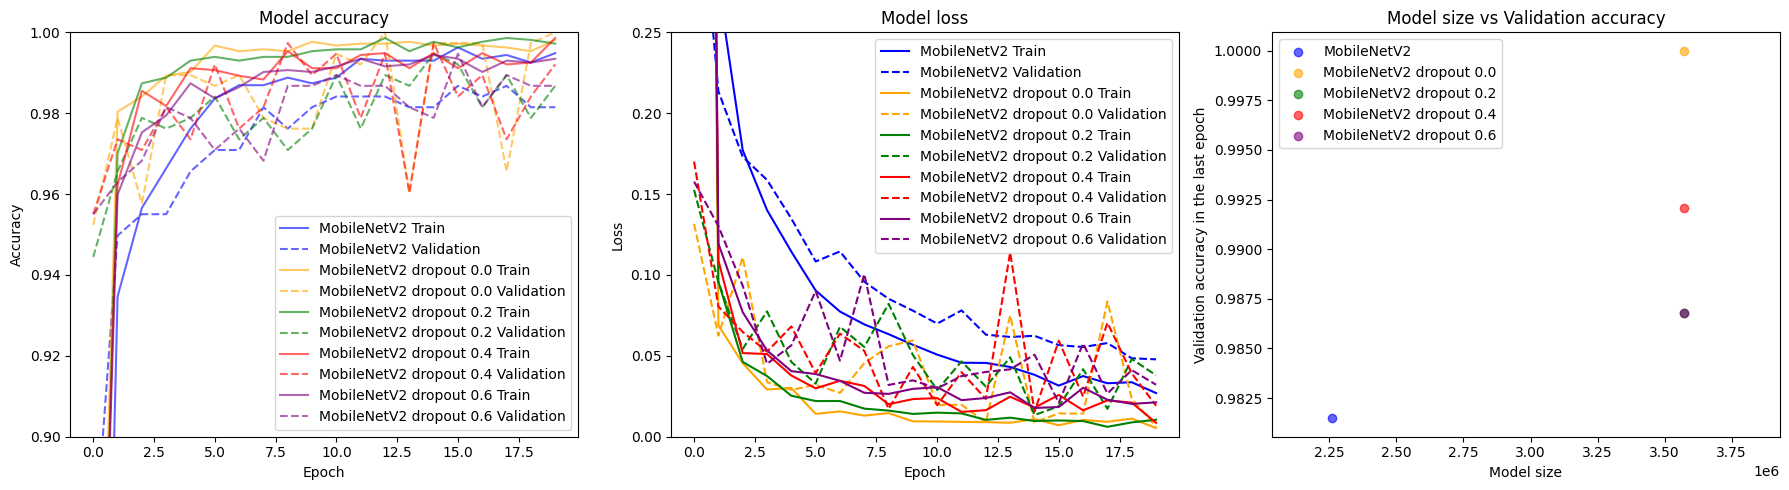

In [22]:
plot_history(
    overview_mobilenetv2, plot_model_size=True, 
    ymin_accuracy=0.9, ymax_accuracy=1.0,
    ymin_loss=0, ymax_loss=0.25
)

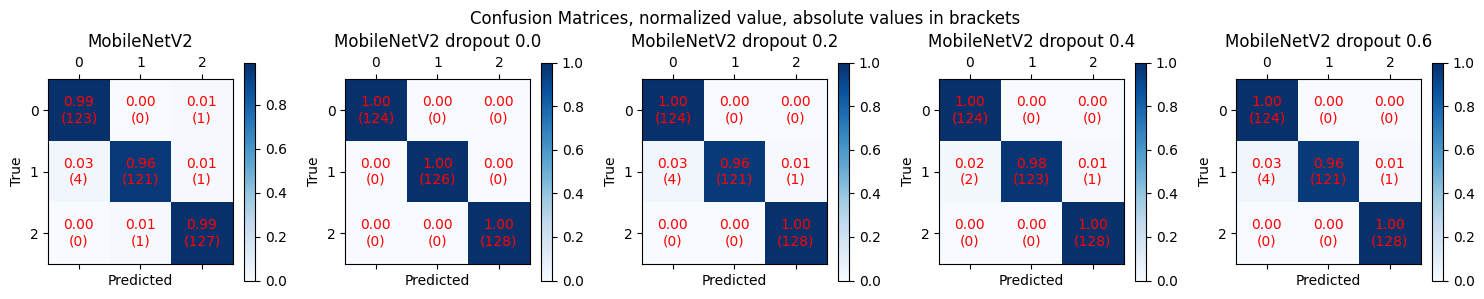

In [23]:
plot_cm(overview_mobilenetv2)

The following has been observed when running this training step multiple times:

- Model performance is more smooth for all models on `training` set compared to `validation` set.

- With the additional layer the `valdidation` accuracy line is more "jumpy".

- Most of the times models with a moderate dropout rate performed best. Therefore deciding to use the additional layer with a moderate dropout rate of `0.4`.

Next comparing performance to using learning rate decay.

In [25]:
dropout_rate=0.4
overview_mobilenetv2_lr_schedule = {}
overview_mobilenetv2_lr_schedule['MobileNetV2'] = overview_mobilenetv2[f'MobileNetV2 dropout {dropout_rate}']

epochs=20
target_size=(160, 160)
batch_size=64

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=epochs * 34,  # Total number of batches in 20 epochs
    decay_rate=(1e-4 / 1e-2) ** (1 / (20 * 34))  # Calculate decay rate
)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

model_mobilenetv2_lr_schedule = create_model(
    func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate, optimizer=optimizer)
overview_mobilenetv2_lr_schedule = train_model(
    model_mobilenetv2_lr_schedule, 
    'MobileNetV2 lr schedule', 
    overview_mobilenetv2_lr_schedule, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
34/34 [==============================] - 11s 202ms/step - loss: 5.2556 - accuracy: 0.7554 - val_loss: 0.2319 - val_accuracy: 0.9074
Epoch 2/20
34/34 [==============================] - 5s 144ms/step - loss: 0.1078 - accuracy: 0.9650 - val_loss: 0.0813 - val_accuracy: 0.9656
Epoch 3/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0728 - accuracy: 0.9734 - val_loss: 0.1084 - val_accuracy: 0.9524
Epoch 4/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0505 - accuracy: 0.9832 - val_loss: 0.0463 - val_accuracy: 0.9841
Epoch 5/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0575 - accuracy: 0.9846 - val_loss: 0.0802 - val_accuracy: 0.9656
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0436 - accuracy: 0.9846 - val_loss: 0.0720 - val_accuracy: 0.9683
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0542 - accuracy: 0.9832 - val_loss: 0.0486 - val_accuracy: 0.9841
Epoch

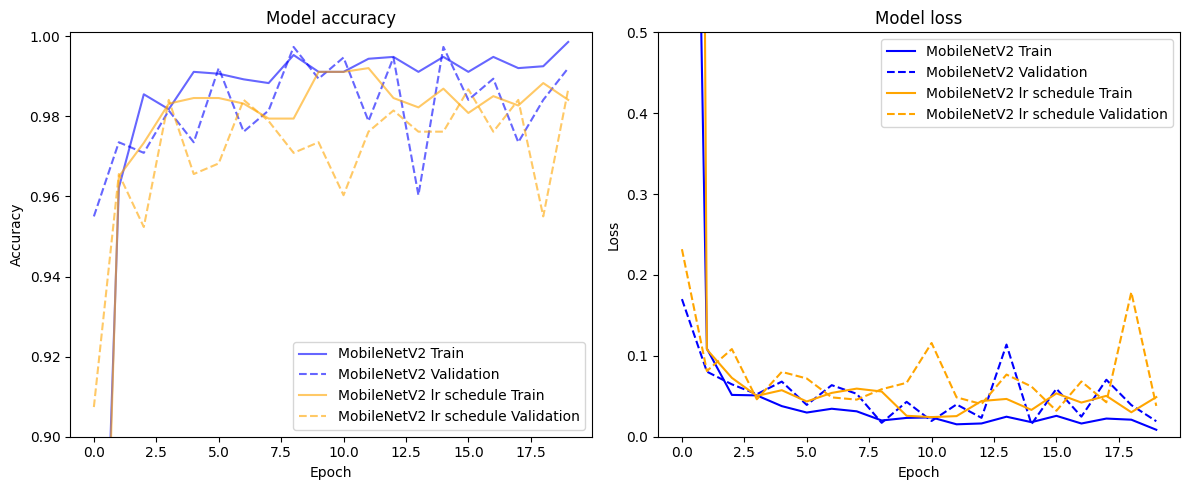

In [26]:
plot_history(
    overview_mobilenetv2_lr_schedule, plot_model_size=False, 
    ymin_accuracy=0.9, ymax_accuracy=1.001,
    ymin_loss=0, ymax_loss=0.5
)

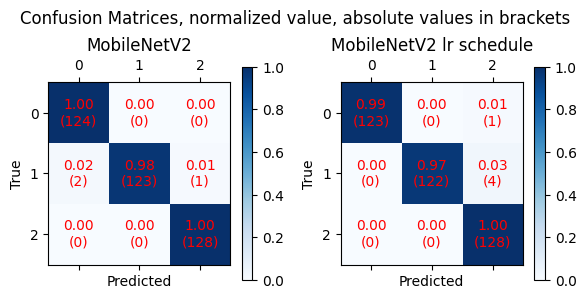

In [27]:
plot_cm(overview_mobilenetv2_lr_schedule)

Running this training step multiple times after another the following has been observed:

- The model trained using the learning rate schedule has a more "jumpy" curve for the valdidation split.

- Therefore deciding to not apply the learning rate schedule for the final model.

## Conclusion/Summary

The following has been tried out. Unfortunately, it was not possible to do the augmentation of the dataset in a reproducible way. Therefore running the notebook again will result in slightly different results.

Furthermore did subsequent runs for trying out what is described in step 2.) below result in different results.

1. **Different base models:**<br>
Training models based on different model architectures. MobileNetv2 has less parameters and performed better.
    - MobileNetv2 with input size (160,160)
    - DenseNet121 with input size (200,200)
    - Remark: DenseNet base model was not available for smaller images sizes
    - MobileNetv2 did perform better within `20` epochs and is smaller

1. **Additional Layer without and with different dropout rates:**<br>
Training MobileNetv2 models with and additional dense layer and different dropout rates and comparing it to the MobileNetv2 model for the previous step.
    - dropout rates `0.0`, `0.2`, `0.4`., and `0.6` have been tried out
    - Curves for validation accuracy are more 'jumpy' than for the 'original' model without the additional layer, but perform better within `20` epochs.
   - Chosing moderate dropout rate of `0.4`
     
1. **Differnt learning rates/schedules:**<br>
Training MobileNetv2 models (additional dense layer and dropout `0.4`) with and without learning rate decay. The model with learning rate decay has again a more 'jumpy' validation accuracy.
   - Selcecting the model without learning rate schedule

Final Model 

- MobileNetv2 with input size (160,160)
- with additional dense layer and dropout `0.4`
- no learning rate decay
- Saving model of best epochs

Using best model for checking performance on test dataset.

Training the final model using `train` and `validation` splits, but saving the best model based on `val_loss`. Afterwards choosing the best model for evaluating it finally with the `test` split.

In [28]:
from datetime import datetime
overview_final = {}

# clear all from memory of previous run
# prevent error from datetime import datetime
overview_final = {}

# clear all from memory of previous run
# prevent error from datetime import datetime
overview_final = {}

epochs=20
target_size = (160, 160)
batch_size = 64
dropout_rate = 0.4

path_model_dir = 'final_model'
shutil.rmtree(path_model_dir, ignore_errors=True)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(path_model_dir, f'model_{datetime.now():%Y%m%d_%H%M%S}'+'-{epoch:02d}-{val_accuracy:.4f}.h5'), 
    monitor='val_accuracy',
    save_weights_only=True,
    verbose=1, 
    save_best_only=True, 
    mode='auto')

optimizer = tf.keras.optimizers.legacy.Adam()
final_model = create_model(func_mobilenetv2, seed=seed, target_size=target_size_mobilenetv2, dropout_rate=dropout_rate)
overview_final = train_model(
    final_model, 
    'MobileNetV2 final', 
    overview_final, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint],
)


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6029 - accuracy: 0.7596
Epoch 1: val_accuracy improved from -inf to 0.95238, saving model to final_model/model_20231219_083711-01-0.9524.h5
34/34 [==============================] - 10s 181ms/step - loss: 1.6029 - accuracy: 0.7596 - val_loss: 0.1204 - val_accuracy: 0.9524
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9617
Epoch 2: val_accuracy improved from 0.95238 to 0.95767, saving model to final_model/model_20231219_083711-02-0.9577.h5
34/34 [==============================] - 5s 148ms/step - loss: 0.1083 - accuracy: 0.9617 - val_loss: 0.1161 - val_accuracy: 0.9577
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9799
Epoch 3: val_accuracy improved from 0.95767 to 0.97090, saving model to final_model/model_20231219_083711-03-0.9709.h5
34/34 [==============================] - 5s 146ms/step - loss: 0.0614 - accuracy: 0.9799 - val_loss: 

Loading model with best `val_loss` and evaluating it on the `validation` split.

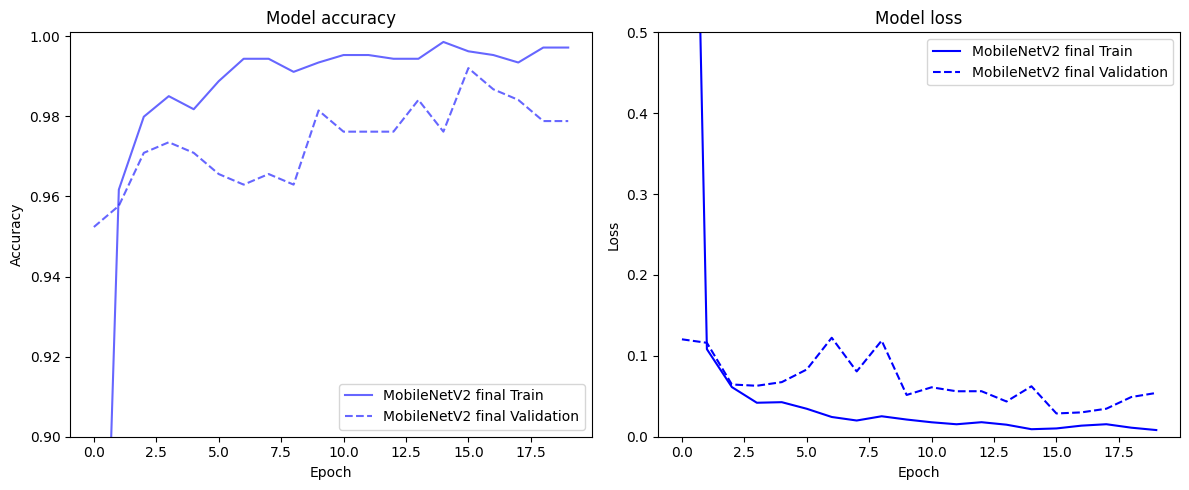

In [29]:
# plot overview_final
plot_history(
    overview_final, plot_model_size=False, 
    ymin_accuracy=0.9, ymax_accuracy=1.001,
    ymin_loss=0, ymax_loss=0.5
)

In [30]:
# get latest file in directory 
path_model_weights = os.path.join(path_model_dir, sorted(os.listdir(path_model_dir))[-1])
print(path_model_weights)
print(os.path.exists(path_model_weights))
print(os.path.exists(os.path.join(path_model_dir,'model.h5')))

final_model/model_20231219_083711-16-0.9921.h5
True
False


In [31]:
final_model.load_weights(path_model_weights)

6/6 [==============================] - 0s 24ms/step - loss: 0.0506 - accuracy: 0.9839
Evaluation on test data
Loss: 0.051
Accuracy: 0.984


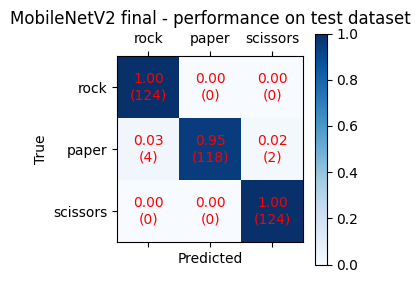

In [32]:
ds_test_prepared = prepare_dataset(dataset.ds_test, seed, target_size=target_size, batch_size=batch_size, augment=False, shuffle=False)
y_true = np.concatenate([y for x, y in ds_test_prepared], axis=0)
y_pred = np.argmax(final_model.predict(ds_test_prepared), axis=1)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
cm_normalized = normalize(cm, axis=1, norm='l1')

cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
fig.colorbar(cax, ax=ax)
ax.set_title('MobileNetV2 final - performance on test dataset')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, f"{cm_normalized[i, j]:.2f}\n({cm[i, j]})", ha="center", va="center", color="red")

# print labels
labels = dataset.ds_info.features['label'].names
num_labels = len(labels)
ax.set_xticks(np.arange(num_labels))
ax.set_yticks(np.arange(num_labels))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)


loss, accuracy = final_model.evaluate(ds_test_prepared)
print("Evaluation on test data")
print(f"Loss: {loss:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Exporting training logic to separate script [`train.py`](train.py).